# <font color=4CBB17>**Redes Neuronales Convolucionales**</font>

In [1]:
# Cargar drive

from google.colab import drive
import sys
import os

drive.mount('/content/drive')
path = '/content/drive/MyDrive/cod/LEA3_health_7'
sys.path.append(path)
os.chdir(path)

os.curdir

Mounted at /content/drive


'.'

In [2]:
# Instalar optuna
!pip install --quiet optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 15.1 MB/s eta 0:00:00


In [3]:
import numpy as np
import joblib ### para cargar array

######## Paquetes para NN #########
import tensorflow as tf
from sklearn import metrics ### para analizar modelo
from sklearn.metrics import roc_auc_score
import pandas as pd


import tensorflow as tf
from tensorflow.keras.utils import to_categorical  # convertir etiquetas a one-hot encoding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint ## guardar mejor modelo


import optuna

In [4]:
# Cargar bases procesadas
X_train_cnn = joblib.load('salidas/X_train_cnn.pkl')
y_train_cnn = joblib.load('salidas/y_train_cnn.pkl')
X_test_cnn = joblib.load('salidas/X_test_cnn.pkl')
y_test_cnn = joblib.load('salidas/y_test_cnn.pkl')

In [34]:
print(type(y_train_cnn))          # Tipo del objeto
print(y_train_cnn.shape)          # Forma: (n_imágenes, alto, ancho, canales)
print(y_train_cnn.dtype)

<class 'numpy.ndarray'>
(8012,)
int64


In [35]:
print(type(y_train_cnn))
print(np.unique(y_train_cnn, return_counts=True))

<class 'numpy.ndarray'>
(array([0, 1]), array([6462, 1550]))


En el contexto del diagnóstico médico, particularmente en el caso del cáncer de piel, suele priorizarse el Recall como métrica clave, ya que lo más importante es no pasar por alto a ningún paciente enfermo. Los falsos negativos representan un mayor riesgo, pues implican que una persona con cáncer pueda no recibir atención médica de manera oportuna. En contraste, los falsos positivos, aunque generan sobrecostos, pueden ser corregidos con estudios clínicos adicionales y no implicarán consecuencias graves en los pacientes.

No obstante, en este caso, se optó por utilizar el AUC como métrica principal durante el desarrollo del modelo. Esta decisión se basa en la naturaleza desbalanceada de los datos, donde los casos positivos (lesiones malignas) son mucho menos frecuentes que los no malignos. Este desbalance puede afectar seriamente métricas como el recall y la precisión, haciéndolas menos representativas del verdadero desempeño global del modelo.

El AUC, en cambio, proporciona una medida robusta e integral del rendimiento del modelo en todos los posibles umbrales de clasificación. Evalúa su capacidad para distinguir correctamente entre las clases positivas y negativas, sin estar condicionado por una distribución específica o un único punto de corte.

In [5]:
input_shape = X_train_cnn.shape[1:]

In [72]:
# Primer modelo, para verificar comportamiento

model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2))),

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten()),
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # Función sigmoide porque es clasificación
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 73, 98, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 49, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 47, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12512)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       800,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,985 (3.07 MB)

 Trainable params: 805,985 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

In [73]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

## checkpoint
checkpoint = ModelCheckpoint(
    filepath='salidas/best_cnn_aucb.keras',
    monitor='val_AUC',
    mode='max',               # Se usa max porque, entre mayor sea el AUC mejor
    save_best_only=True,
    verbose=1
)

history = model.fit(
    X_train_cnn, y_train_cnn,
    batch_size=100,
    epochs=10,
    validation_data=(X_test_cnn, y_test_cnn),
    callbacks=checkpoint
)

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 742ms/step - AUC: 0.5527 - loss: 0.5162
Epoch 1: val_AUC improved from -inf to 0.72402, saving model to salidas/best_cnn_aucb.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 70s 828ms/step - AUC: 0.5537 - loss: 0.5157 - val_AUC: 0.7240 - val_loss: 0.4288
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - AUC: 0.7232 - loss: 0.4258
Epoch 2: val_AUC improved from 0.72402 to 0.78421, saving model to salidas/best_cnn_aucb.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 64s 605ms/step - AUC: 0.7234 - loss: 0.4258 - val_AUC: 0.7842 - val_loss: 0.4111
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - AUC: 0.7844 - loss: 0.3968
Epoch 3: val_AUC improved from 0.78421 to 0.82769, saving model to salidas/best_cnn_aucb.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 81s 595ms/step - AUC: 0.7846 - loss: 0.3967 - val_AUC: 0.8277 - val_loss: 0.3823
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - AUC: 0.8088 - loss: 0.3840
Epoch 4: val_AUC did not improve from 0.82769
81/81 ━━━━━━━━━━━━━━━━━━

In [40]:
print(history.history.keys())

dict_keys(['AUC', 'loss', 'val_AUC', 'val_loss'])


In [71]:
from tensorflow.keras import backend as K
K.clear_session()

In [68]:
# Modelo CNN con Dropout
model1 = Sequential()

model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model1.add(MaxPool2D(pool_size=(2, 2)))
model1.add(Dropout(0.1))

model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPool2D(pool_size=(2, 2)))
model1.add(Dropout(0.1))

model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(1, activation='sigmoid'))

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 73, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 36, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 17, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25024)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,203,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,222,721 (12.29 MB)

 Trainable params: 3,222,721 (12.29 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
print(np.unique(y_train_cnn))

[0 1]


In [69]:
model1.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['AUC'])
## checkpoint
checkpoint1 = ModelCheckpoint(
    filepath='salidas/best_cnn_rec.keras',
    monitor='val_AUC',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Debido a que las clases estan desbalanceadas

from sklearn.utils import class_weight

'''class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_cnn),
    y=y_train_cnn
)
class_weights = dict(enumerate(class_weights))'''


history1 = model1.fit(
    X_train_cnn, y_train_cnn,
    batch_size=64,
    epochs=10,
   # class_weight=class_weights,
    validation_data=(X_test_cnn, y_test_cnn),
    callbacks=checkpoint1
)

Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 819ms/step - AUC: 0.6152 - loss: 0.5309
Epoch 1: val_AUC improved from -inf to 0.73433, saving model to salidas/best_cnn_rec.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 113s 872ms/step - AUC: 0.6156 - loss: 0.5304 - val_AUC: 0.7343 - val_loss: 0.4415
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 771ms/step - AUC: 0.7531 - loss: 0.4248
Epoch 2: val_AUC improved from 0.73433 to 0.76332, saving model to salidas/best_cnn_rec.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 140s 856ms/step - AUC: 0.7531 - loss: 0.4247 - val_AUC: 0.7633 - val_loss: 0.4231
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 771ms/step - AUC: 0.7723 - loss: 0.4098
Epoch 3: val_AUC improved from 0.76332 to 0.81598, saving model to salidas/best_cnn_rec.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 142s 855ms/step - AUC: 0.7724 - loss: 0.4097 - val_AUC: 0.8160 - val_loss: 0.4057
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 841ms/step - AUC: 0.8119 - loss: 0.3841
Epoch 4: val_AUC did not improve from 0.81598
126/126 ━━

In [75]:
from sklearn.utils import class_weight

from sklearn.metrics import recall_score

def objective(trial):
    K.clear_session()

    # Hiperparámetros a optimizar
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.2, step=0.05)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd'])

    print(f"Trial {trial.number} - Params:dr={dropout_rate} , lr={learning_rate:.4f}")


    # Modelo CNN
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    # Optimizador
    if optimizer_name == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)


    model.compile(optimizer=opt, loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.AUC(name='AUC')])

    checkpoint3 = ModelCheckpoint(
      filepath='salidas/best_cnn_optuna.keras',
      monitor='val_AUC',
      mode='max',
      save_best_only=True,
      verbose=1)


    # Entrenamiento
    model.fit(
        X_train_cnn, y_train_cnn,
        validation_data=(X_test_cnn, y_test_cnn),
        epochs=5,
        batch_size=64,
        verbose=0,
        callbacks=checkpoint3
    )

    model_win=tf.keras.models.load_model('salidas/best_cnn_optuna.keras')

    y_pred_prob = model_win.predict(X_test_cnn).ravel()
    auc = roc_auc_score(y_test_cnn, y_pred_prob)

    # Save best model in trial attributes
    trial.set_user_attr("model", model_win)

    return auc

# Run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=3)

# Get best model
best_trial = study.best_trial
best_model = best_trial.user_attrs["model"]

# Final evaluation
test_loss, test_auc = best_model.evaluate(X_test_cnn, y_test_cnn)
print(f"\nMejor AUC on test set: {test_auc:.4f}")
best_model.summary()

[I 2025-06-09 20:23:22,835] A new study created in memory with name: no-name-d433dc03-11dd-4795-9473-74cf3563fdad


Trial 0 - Params:dr=0.15000000000000002 , lr=0.0019

Epoch 1: val_AUC improved from -inf to 0.71553, saving model to salidas/best_cnn_optuna.keras

Epoch 2: val_AUC improved from 0.71553 to 0.74787, saving model to salidas/best_cnn_optuna.keras

Epoch 3: val_AUC improved from 0.74787 to 0.75442, saving model to salidas/best_cnn_optuna.keras

Epoch 4: val_AUC improved from 0.75442 to 0.78020, saving model to salidas/best_cnn_optuna.keras

Epoch 5: val_AUC did not improve from 0.78020
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step


[I 2025-06-09 20:35:32,737] Trial 0 finished with value: 0.7800249537148838 and parameters: {'dropout_rate': 0.15000000000000002, 'learning_rate': 0.0019039287029156127, 'optimizer': 'adam'}. Best is trial 0 with value: 0.7800249537148838.


Trial 1 - Params:dr=0.2 , lr=0.0125


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_AUC improved from -inf to 0.67912, saving model to salidas/best_cnn_optuna.keras

Epoch 2: val_AUC did not improve from 0.67912

Epoch 3: val_AUC improved from 0.67912 to 0.68468, saving model to salidas/best_cnn_optuna.keras

Epoch 4: val_AUC improved from 0.68468 to 0.71399, saving model to salidas/best_cnn_optuna.keras

Epoch 5: val_AUC improved from 0.71399 to 0.75511, saving model to salidas/best_cnn_optuna.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step


[I 2025-06-09 20:46:04,283] Trial 1 finished with value: 0.7557755775577557 and parameters: {'dropout_rate': 0.2, 'learning_rate': 0.012513680758884099, 'optimizer': 'sgd'}. Best is trial 0 with value: 0.7800249537148838.


Trial 2 - Params:dr=0.15000000000000002 , lr=0.0069


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_AUC improved from -inf to 0.63474, saving model to salidas/best_cnn_optuna.keras

Epoch 2: val_AUC improved from 0.63474 to 0.68330, saving model to salidas/best_cnn_optuna.keras

Epoch 3: val_AUC improved from 0.68330 to 0.68818, saving model to salidas/best_cnn_optuna.keras

Epoch 4: val_AUC improved from 0.68818 to 0.69202, saving model to salidas/best_cnn_optuna.keras

Epoch 5: val_AUC improved from 0.69202 to 0.69844, saving model to salidas/best_cnn_optuna.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step


[I 2025-06-09 20:58:05,998] Trial 2 finished with value: 0.6979052501873076 and parameters: {'dropout_rate': 0.15000000000000002, 'learning_rate': 0.006928760914324356, 'optimizer': 'sgd'}. Best is trial 0 with value: 0.7800249537148838.


63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - AUC: 0.7765 - loss: 0.4599

Mejor AUC on test set: 0.7802


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 73, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 36, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 17, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25024)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,203,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,668,165 (36.88 MB)

 Trainable params: 3,222,721 (12.29 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,445,444 (24.59 MB)

A pesar de realizar una búsqueda de hiperparámetros utilizando Optuna, los modelos generados no superaron el rendimiento alcanzado por el modelo 2 con dropout. Este modelo logró un AUC en test de 0.8639, lo cual nos indica que el modelo tiene capacidad para discriminar entre clases positivas y negativas. La incorporación del dropout probablemente ayudó a reducir el sobreajuste, mejorando así la capacidad del modelo para generalizar sobre datos no vistos.

En vista de estos resultados, se decide seleccionar el modelo 2 con dropout como la mejor alternativa, ya que ofrece un rendimiento competitivo y estable sin necesidad de una configuración adicional compleja, ya que la optimización con optuna tardo 35 minutos aproximadamente.

In [83]:
best_auc = tf.keras.models.load_model('salidas/best_cnn_rec.keras')
test_loss, test_auc = best_auc.evaluate(X_test_cnn, y_test_cnn, verbose=2)
print("Test AUC:", test_auc)

63/63 - 6s - 88ms/step - AUC: 0.8639 - loss: 0.3520
Test AUC: 0.8638768792152405


63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step


Text(0.5, 1.0, 'probabilidades imágenes en entrenamiento')

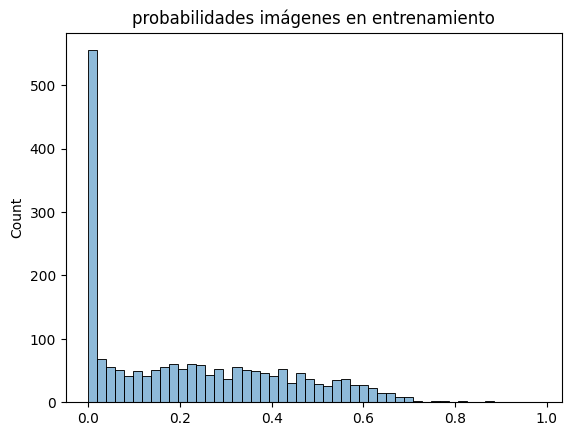

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

####probabilidades en evaluación para grupo 1 (tienen cancer de piel) #######
prob = best_auc.predict(X_test_cnn)
sns.histplot(prob, legend=False, bins=50)
plt.title("probabilidades imágenes en entrenamiento")### conocer el comportamiento de las probabilidades para revisar threshold



63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step
              precision    recall  f1-score   support

           0       0.99      0.41      0.58      1599
           1       0.30      0.99      0.46       404

    accuracy                           0.53      2003
   macro avg       0.65      0.70      0.52      2003
weighted avg       0.85      0.53      0.55      2003



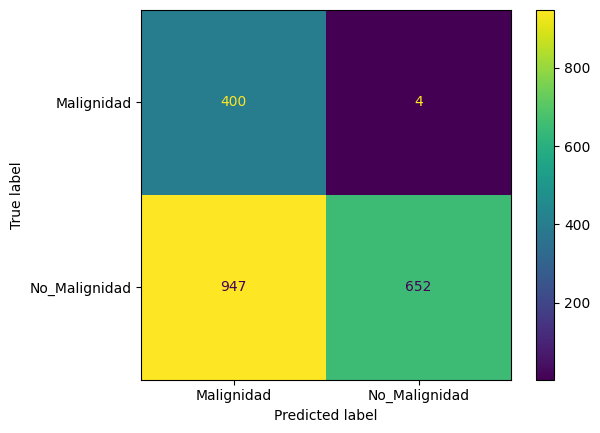

In [91]:
# Matriz de confusión test
pred_test = (best_auc.predict(X_test_cnn)>=0.05).astype('int')
cm = metrics.confusion_matrix(y_test_cnn,pred_test, labels=[1,0])
disp = metrics.ConfusionMatrixDisplay(cm,display_labels=['Malignidad', 'No_Malignidad'])
disp.plot()

print(metrics.classification_report(y_test_cnn, pred_test))


In [92]:
prob = best_auc.predict(X_test_cnn)


clas = [
    'No ident' if prob > 0.05 else
    "No maligno"
    for prob in prob
]
clases, count =np.unique(clas, return_counts=True)

count*100/np.sum(count)


63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step


array([67.24912631, 32.75087369])